In [1]:
import os
import random
import time

from PIL import Image
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

/Users/patryk/venv-torch/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/patryk/venv-torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/patryk/venv-torch/lib/python3.9/site-packages/transformers/utils/generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


### Displaying random image from each class

In [2]:
labels = os.listdir('birds-dataset/')
print(len(labels))
labels

25


['White Wagtail',
 'Cattle Egret',
 'House Crow',
 'Rufous Treepie',
 'Hoopoe',
 'Indian Grey Hornbill',
 'Indian Roller',
 'Red-Wattled Lapwing',
 'Asian Green Bee-Eater',
 'Brown-Headed Barbet',
 'Ruddy Shelduck',
 'Indian Peacock',
 'Northern Lapwing',
 'Forest Wagtail',
 'Common Tailorbird',
 'Coppersmith Barbet',
 'Common Myna',
 'Common Rosefinch',
 'Common Kingfisher',
 'Indian Pitta',
 'White-Breasted Waterhen',
 'Sarus Crane',
 'Jungle Babbler',
 'White-Breasted Kingfisher',
 'Gray Wagtail']

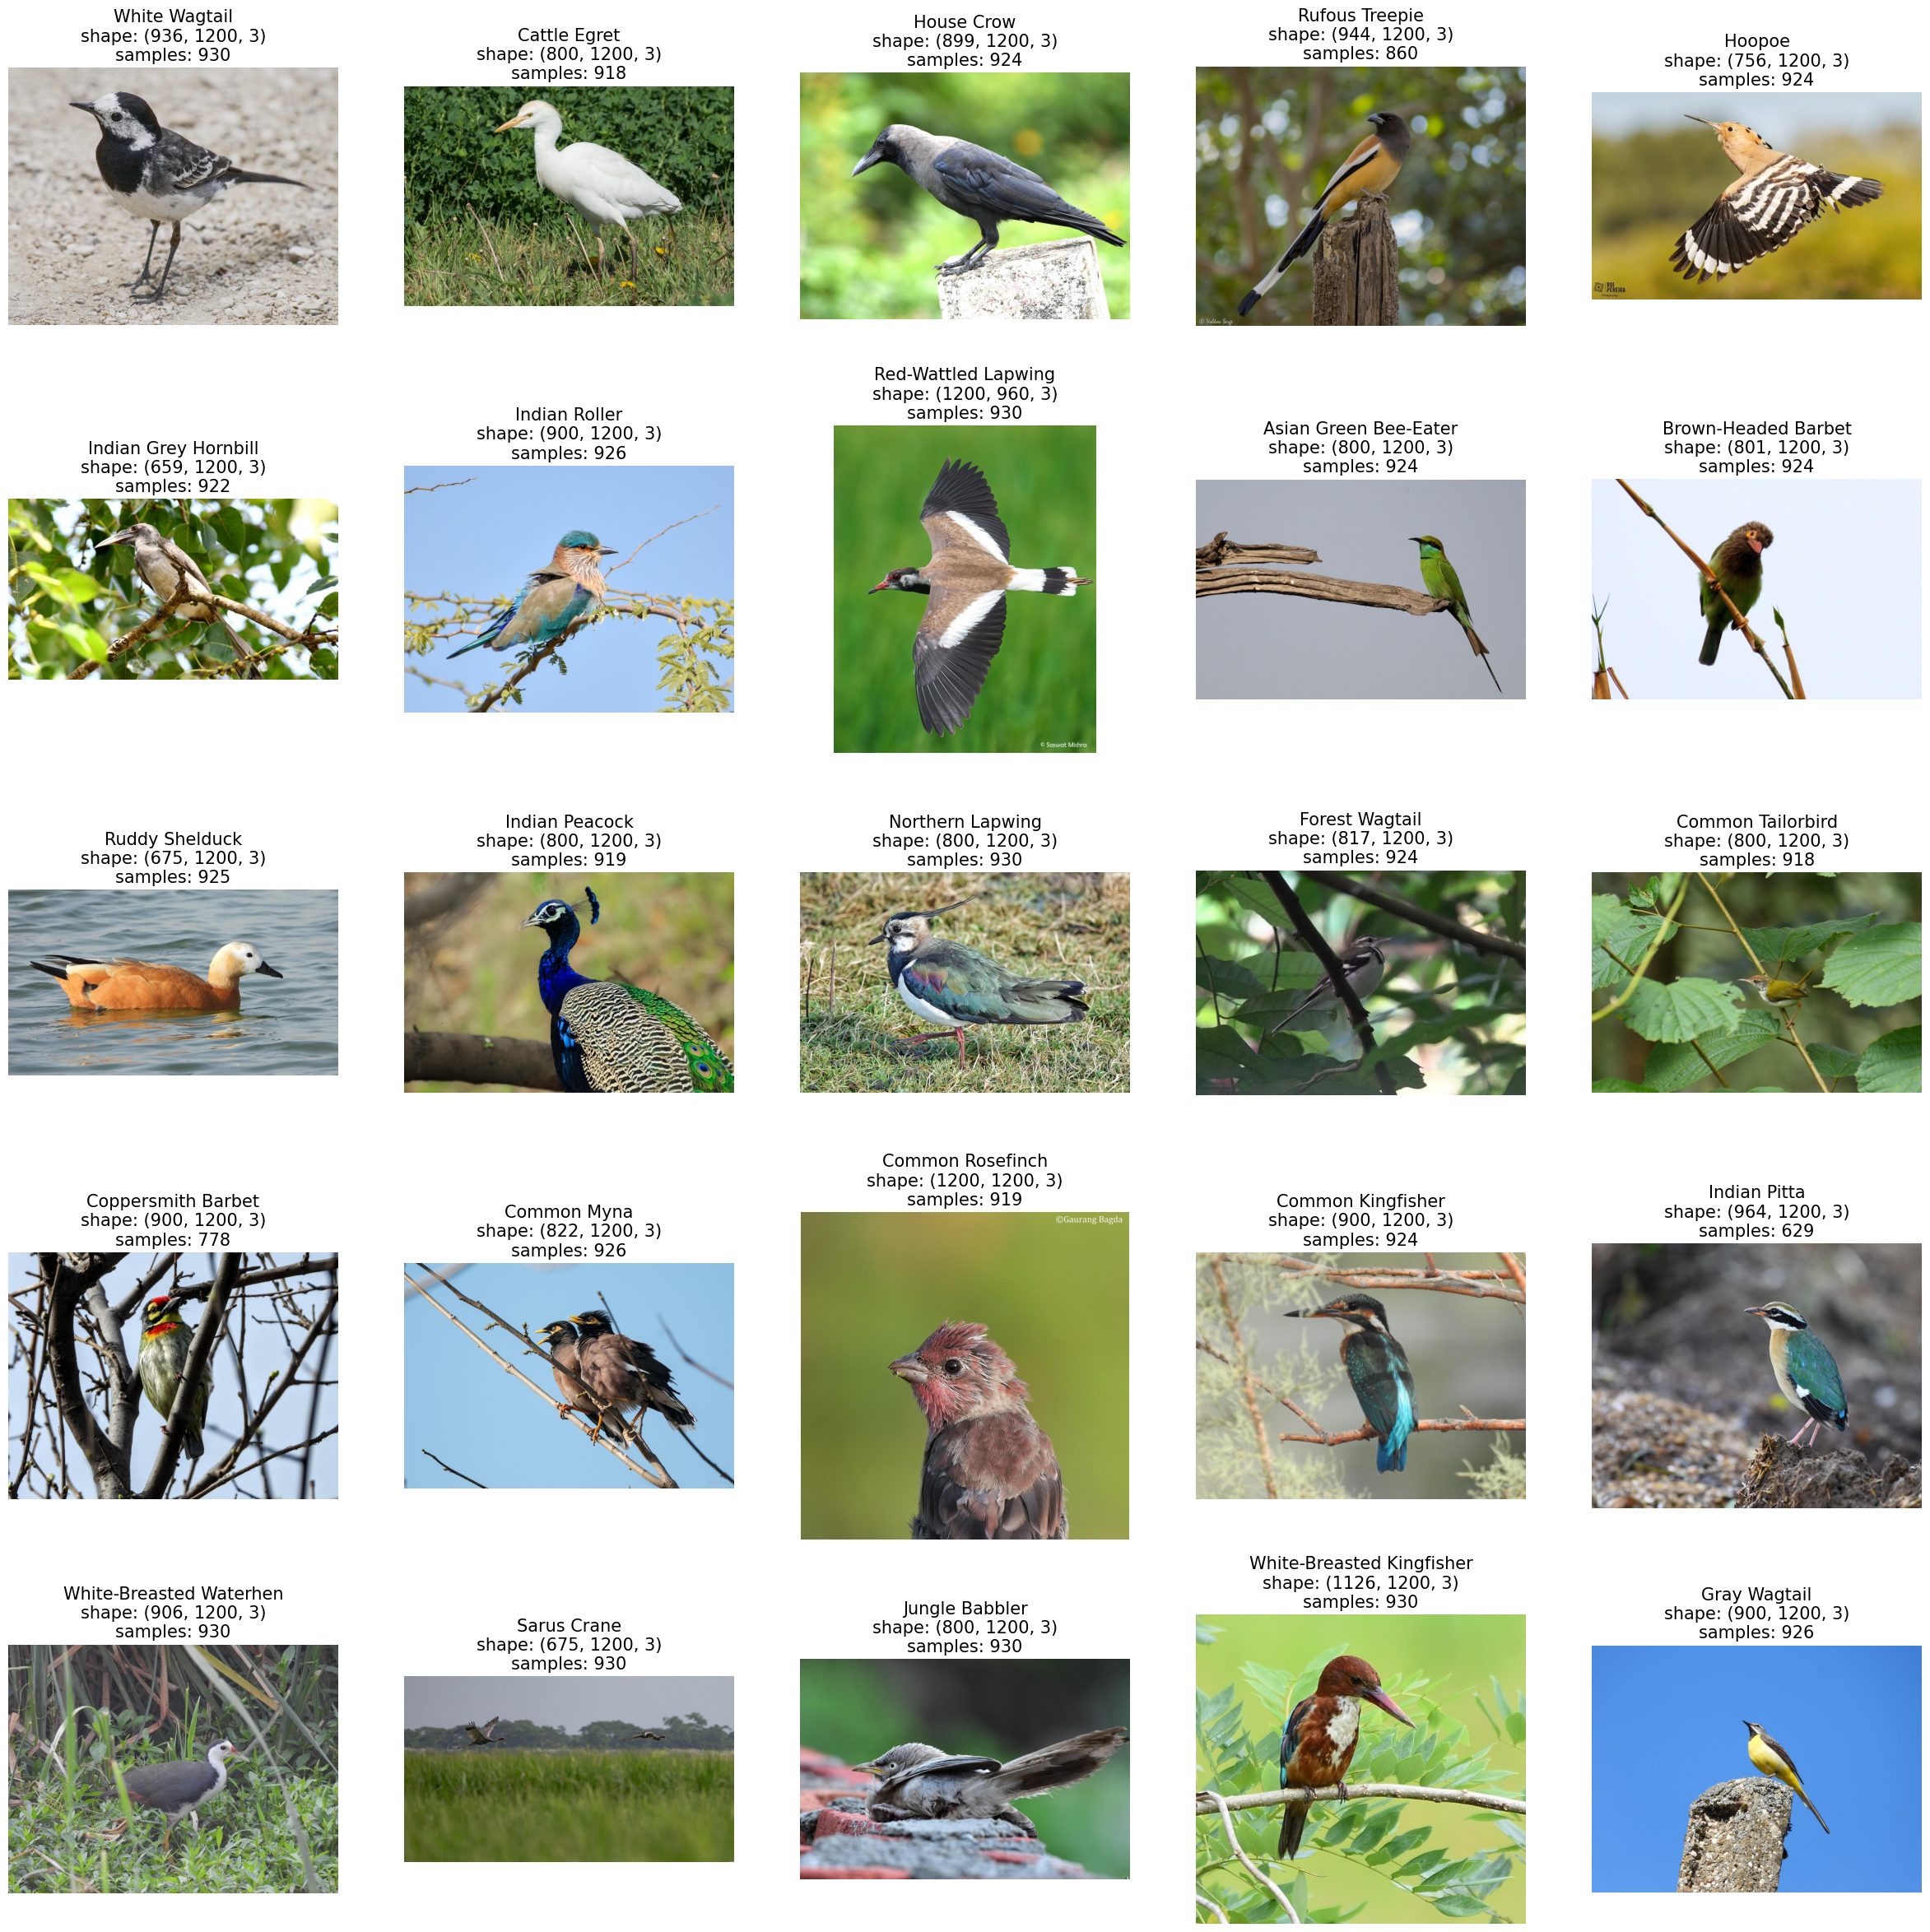

In [4]:
plt.figure(figsize=(30, 30))
for i, label in enumerate(labels):
    img_path = os.path.join('birds-dataset', label)
    imgs = os.listdir(img_path)
    n_images = len(imgs)
    img = random.choice(imgs)
    img = plt.imread(os.path.join(img_path, img))
    plt.subplot(5, 5, i+1)
    plt.imshow(img)
    plt.title(f'{label}\nshape: {img.shape}\nsamples: {n_images}', fontsize=15)
    plt.axis('off')

#### Converting all images to RGB

In [6]:
for label in os.listdir('birds-dataset/'):
    for image in os.listdir(os.path.join('birds-dataset', label)):
        img_path = os.path.join('birds-dataset', label, image)
        img = Image.open(img_path).convert('RGB')
        img.save(img_path)

### Dataset preparation

In [3]:
class BirdsImageDataset(Dataset):
    def __init__(self, img_dir=None, data=None, labels=None, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        
        if img_dir is not None:
            self.class_folders = sorted(os.listdir(img_dir))
            self.data = []
            self.labels = []
            self.class_to_idx = {}

            for i, class_folder in enumerate(self.class_folders):
                class_path = os.path.join(img_dir, class_folder)
                for img in os.listdir(class_path):
                    img_path = os.path.join(class_path, img)
                    self.data.append(img_path)
                    self.labels.append(i)
                    self.class_to_idx[class_folder] = i
        else:
            self.data = data
            self.labels = labels
                
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image_path = self.data[idx]
        labels = self.labels[idx]
        image = Image.open(image_path)

        if self.transform is not None:
            image = self.transform(image)
            
        return image, labels


In [4]:
train_transfroms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
test_transfroms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
])

In [5]:
dataset = BirdsImageDataset('birds-dataset/')

{'Asian Green Bee-Eater': 0, 'Brown-Headed Barbet': 1, 'Cattle Egret': 2, 'Common Kingfisher': 3, 'Common Myna': 4, 'Common Rosefinch': 5, 'Common Tailorbird': 6, 'Coppersmith Barbet': 7, 'Forest Wagtail': 8, 'Gray Wagtail': 9, 'Hoopoe': 10, 'House Crow': 11, 'Indian Grey Hornbill': 12, 'Indian Peacock': 13, 'Indian Pitta': 14, 'Indian Roller': 15, 'Jungle Babbler': 16, 'Northern Lapwing': 17, 'Red-Wattled Lapwing': 18, 'Ruddy Shelduck': 19, 'Rufous Treepie': 20, 'Sarus Crane': 21, 'White Wagtail': 22, 'White-Breasted Kingfisher': 23, 'White-Breasted Waterhen': 24}
Total images 22620
Class idx: 7


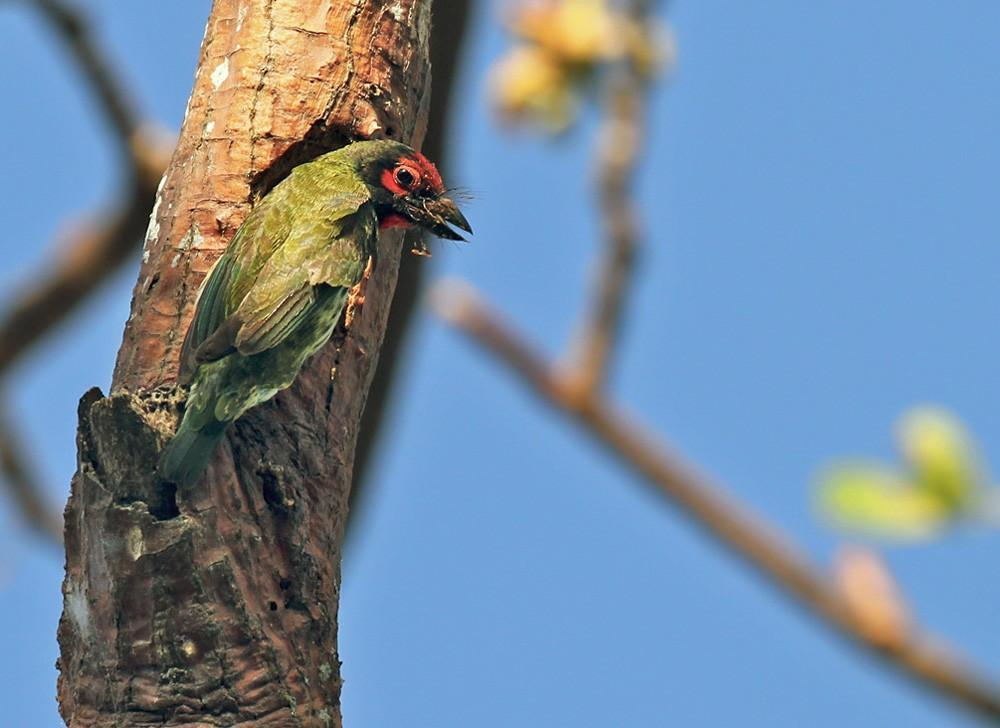

In [6]:
print(dataset.class_to_idx)
print(f'Total images {len(dataset)}')
r_image = dataset[random.randint(0, len(dataset))]
print(f'Class idx: {r_image[1]}')
r_image[0]

In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(dataset.data, 
                                                                   dataset.labels,
                                                                   test_size=0.2,
                                                                   random_state=42,
                                                                   stratify=dataset.labels)

In [8]:
train_data, val_data, train_labels, val_labels = train_test_split(train_data,
                                                                  train_labels,
                                                                  test_size=0.2,
                                                                  random_state=42,
                                                                  stratify=train_labels)

In [9]:
train_dataset = BirdsImageDataset(data=train_data, labels=train_labels, transform=train_transfroms)
val_dataset = BirdsImageDataset(data=val_data, labels=val_labels, transform=test_transfroms)
test_dataset = BirdsImageDataset(data=test_data, labels=test_labels, transform=test_transfroms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
for batch in train_loader:
    images, labels = batch
    print(f'images shape: {images.size()}')
    print(f'labels shape: {labels.size()}')
    break

images shape: torch.Size([32, 3, 224, 224])
labels shape: torch.Size([32])


In [11]:
dataloaders = {"train": train_loader, "val": val_loader, "test": test_loader}
dataset_sizes = {"train": len(train_dataset), "val": len(val_dataset), "test": len(test_dataset)}

In [12]:
dataset_sizes

{'train': 14476, 'val': 3620, 'test': 4524}

### Image classification

In [13]:
device = torch.device('mps')

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_f1 = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                epoch_preds = []
                epoch_labels = []

                for inputs, labels in dataloaders[phase]:

                    epoch_labels.extend(labels.cpu().data)
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        epoch_preds.extend(preds.cpu().data)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]
                epoch_f1 = f1_score(epoch_labels, epoch_preds, average='macro')

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}, F1: {epoch_f1:.4f}')

                if phase == 'val' and epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val f1 score: {best_f1:4f}')

        model.load_state_dict(torch.load(best_model_params_path))
    return model

#### Finetuning Resnet18

In [19]:
rn18 = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = rn18.fc.in_features
rn18.fc = nn.Linear(num_ftrs, 25)

rn18 = rn18.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rn18.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [20]:
rn18 = train_model(rn18, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.1212 Acc: 0.6715, F1: 0.6714
val Loss: 1.2068 Acc: 0.6757, F1: 0.6785

Epoch 1/9
----------
train Loss: 0.6774 Acc: 0.8019, F1: 0.8027
val Loss: 0.7091 Acc: 0.7983, F1: 0.7990

Epoch 2/9
----------
train Loss: 0.5558 Acc: 0.8347, F1: 0.8358
val Loss: 0.6008 Acc: 0.8279, F1: 0.8295

Epoch 3/9
----------
train Loss: 0.4623 Acc: 0.8642, F1: 0.8649
val Loss: 0.6996 Acc: 0.8055, F1: 0.8085

Epoch 4/9
----------
train Loss: 0.4287 Acc: 0.8706, F1: 0.8710
val Loss: 0.4531 Acc: 0.8732, F1: 0.8752

Epoch 5/9
----------
train Loss: 0.3538 Acc: 0.8920, F1: 0.8926
val Loss: 0.5973 Acc: 0.8329, F1: 0.8355

Epoch 6/9
----------
train Loss: 0.3379 Acc: 0.8980, F1: 0.8986
val Loss: 0.6236 Acc: 0.8392, F1: 0.8397

Epoch 7/9
----------
train Loss: 0.1785 Acc: 0.9454, F1: 0.9457
val Loss: 0.2997 Acc: 0.9169, F1: 0.9180

Epoch 8/9
----------
train Loss: 0.1194 Acc: 0.9639, F1: 0.9642
val Loss: 0.2890 Acc: 0.9202, F1: 0.9213

Epoch 9/9
----------
train Loss: 0.0969 Acc: 0

In [21]:
torch.save(rn18.state_dict(), "models/rn18.pt")

#### Mobilenet

In [15]:
mbnet = models.mobilenet_v2(weights='IMAGENET1K_V1')
num_ftrs = mbnet.classifier[1].in_features
mbnet.classifier[1] = nn.Linear(num_ftrs, 25)

mbnet = mbnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mbnet.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [16]:
mbnet = train_model(mbnet, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.9284 Acc: 0.7243, F1: 0.7239
val Loss: 0.5596 Acc: 0.8348, F1: 0.8339

Epoch 1/9
----------
train Loss: 0.5750 Acc: 0.8282, F1: 0.8292
val Loss: 0.5518 Acc: 0.8486, F1: 0.8490

Epoch 2/9
----------
train Loss: 0.4558 Acc: 0.8655, F1: 0.8662
val Loss: 0.4533 Acc: 0.8707, F1: 0.8721

Epoch 3/9
----------
train Loss: 0.4241 Acc: 0.8733, F1: 0.8740
val Loss: 0.4101 Acc: 0.8749, F1: 0.8803

Epoch 4/9
----------
train Loss: 0.3840 Acc: 0.8842, F1: 0.8846
val Loss: 0.4755 Acc: 0.8550, F1: 0.8551

Epoch 5/9
----------
train Loss: 0.3524 Acc: 0.8924, F1: 0.8931
val Loss: 0.4346 Acc: 0.8746, F1: 0.8777

Epoch 6/9
----------
train Loss: 0.3265 Acc: 0.8994, F1: 0.9000
val Loss: 0.3594 Acc: 0.8931, F1: 0.8929

Epoch 7/9
----------
train Loss: 0.1803 Acc: 0.9453, F1: 0.9457
val Loss: 0.2160 Acc: 0.9412, F1: 0.9420

Epoch 8/9
----------
train Loss: 0.1268 Acc: 0.9602, F1: 0.9605
val Loss: 0.2026 Acc: 0.9448, F1: 0.9457

Epoch 9/9
----------
train Loss: 0.1092 Acc: 0

In [17]:
torch.save(mbnet.state_dict(), "models/mbnet.pth")